In [ ]:
import glob
import h5py
import shutil

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from pathlib import Path
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline
import os
import tensorflow as tf
import imgaug as aug

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.compat.v1.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Set the session in keras
tf.compat.v1.keras.backend.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 30,zoom_range = 0.2,width_shift_range=0.1,  height_shift_range=0.1,  horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab_Notebooks/chest_xray/train',
        target_size=(150, 150),
        class_mode='binary')

Found 5216 images belonging to 2 classes.


In [ ]:
valid_datagen = ImageDataGenerator()

valid_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab_Notebooks/chest_xray/val',
        target_size=(150, 150),
        class_mode='binary')

Found 16 images belonging to 2 classes.


In [ ]:
def build_model():
    input_img = Input(shape=(150,150,3), name='ImageInput')
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=2,padding='same')(x)
    
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=2,padding='same')(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = SeparableConv2D(128, (2,2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=2,padding='same')(x)
    
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), strides=2,padding='same')(x)
        
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=1, activation='sigmoid')(x)

    
    model = Model(inputs=input_img, outputs=x)
    return model




In [ ]:
model =  build_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)       

In [ ]:

f = h5py.File('/content/drive/My Drive/Colab_Notebooks/chest_xray/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()
 

"\nf = h5py.File('/content/drive/My Drive/Colab_Notebooks/chest_xray/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')\n\n# Select the layers for which you want to set weight.\n\nw,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']\nmodel.layers[1].set_weights = [w,b]\n\nw,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']\nmodel.layers[2].set_weights = [w,b]\n\nw,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']\nmodel.layers[4].set_weights = [w,b]\n\nw,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']\nmodel.layers[5].set_weights = [w,b]\n\nf.close()\nmodel.summary()\n"

In [ ]:
opt = Adam()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
history = model.fit_generator(train_generator,epochs = 12 ,steps_per_epoch=163,validation_data = valid_generator,callbacks=[learning_rate_reduction])                  

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/12
163/163 [==============================] - 2432s 15s/step - loss: 0.3888 - accuracy: 0.8738 - val_loss: 0.8286 - val_accuracy: 0.6250
Epoch 2/12
163/163 [==============================] - 77s 470ms/step - loss: 0.1808 - accuracy: 0.9310 - val_loss: 0.7449 - val_accuracy: 0.5625
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9400
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 77s 475ms/step - loss: 0.1573 - accuracy: 0.9400 - val_loss: 4.7926 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 78s 478ms/step - loss: 0.1224 - accuracy: 0.9559 - val_loss: 2.2319 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9611
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163

In [ ]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab_Notebooks/chest_xray/test',
        target_size=(150, 150),
        class_mode='binary')

Found 624 images belonging to 2 classes.


In [ ]:
test_loss, test_score = model.evaluate(test_generator, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

20/20 [==============================] - 275s 14s/step - loss: 0.4192 - accuracy: 0.9135
Loss on test set:  0.41915056109428406
Accuracy on test set:  0.9134615659713745


In [ ]:
test_loss, test_score = model.evaluate(test_generator, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

20/20 [==============================] - 196s 10s/step - loss: 2.2998 - accuracy: 0.7067
Loss on test set:  2.2997562885284424
Accuracy on test set:  0.7067307829856873


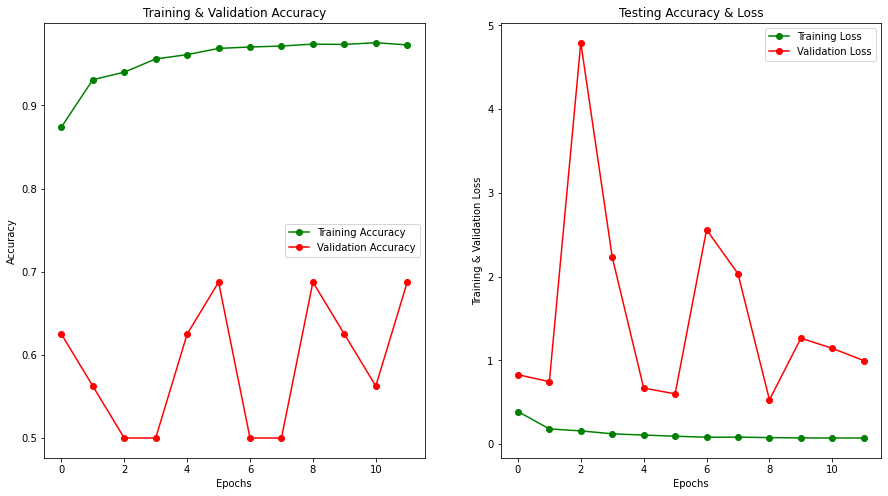

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15,8)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()